# Deep Learning with Python

## 8.2 DeepDream

> DeepDream

DeepDream 是一种让机器修改图像技术，它利用卷积神经网络，可以作出很迷幻的图像：

![DeepDream 输出图像示例](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghqnj1501xj313t0u0e84.jpg)

由于 DeepDream 用的 CNN 是在 ImageNet 上训练的，而 ImageNet 里有大量的动物图片，所以，DeepDream 生成的图像里有很多动物、动物的一部分的伪影。

DeepDream 使用的算法与卷积神经网络过滤器可视化技术很类似。回忆一下，卷积神经网络过滤器可视化所做的操作是：反向运行卷积神经网络，从一张带随机噪点的空白图像输入，做梯度上升，使某过滤器激活最大化。

DeepDream  与过滤器可视化的主要区别在于：

- 在 DeepDream 中，我们尝试将所有层的激活最大化，而不只是某一层，这样，会有大量的可视化特征混合在一起——生成更加迷幻的图像。
- 从一张现有的图像开始，而不是从随机噪点的输入开始，这样生成的图像中会包含输入图像中已存在的视觉模式，并以将其中的一些元素扭曲——生成更加迷幻的图像。
- 输入图像会在不同的尺度上进行处理——这些尺度称为「八度」(octave)，这可以提高输出的质量。 

### 用 Keras 实现 DeepDream

首先，我们需要选定一个在 ImageNet 上预训练的卷积神经网络：VGG16、Inception、ResNet50 等等都可以。实践证明，Inception 可以生成的比较好，所以这里我们使用 Keras 内置的 Inception V3 模型。

In [2]:
# 不使用及时执行模式

import tensorflow as tf

tf.compat.v1.disable_eager_execution()  # See https://github.com/tensorflow/tensorflow/issues/33135

In [3]:
# 加载预训练的 Inception V3 模型

from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K

K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


接下来定义损失——需要用梯度上升最大化的量。DeepDream 中，我们要同时将多个层的所有过滤器激活最大化。具体的实现是：对一组靠近顶部的层激活的 L2 范数进行加权求和，然后求出这个值的最大化。层的选择、以及权重分配对生成的结果影响很大：

- 靠近底部的层会生成基本的几何图案；
- 靠近顶部的层会生成能够看出某些物品的图像（ImageNet 中的图案，比如鸟或狗）

这里就随便选几个了：

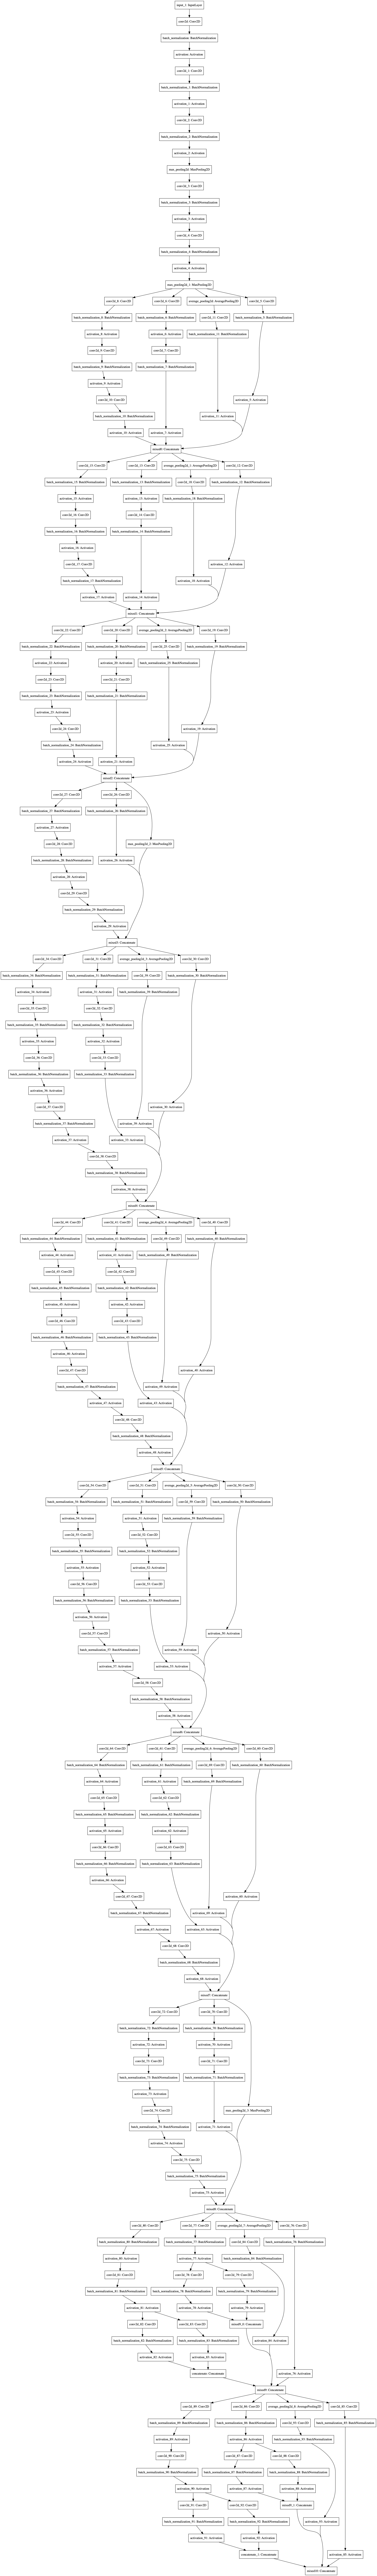

In [4]:
# 输出 Inception V3 模型的结构，在其中选择层

import tensorflow as tf

tf.keras.utils.plot_model(model)

In [208]:
# DeepDream 配置

layer_contributions = {
    'mixed4': 0.0,
    'mixed5': 3.0,
    'mixed6': 2.0,
    'mixed7': 1.5,
}

求对于这些被选中层的损失：

In [209]:
# 定义需要最大化的损失

layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # loss += coeff * K.sum(K.square(activation[:, 2: -2, :])) / scaling
    # 应该用下面的代码👇。参考：https://github.com/fchollet/deep-learning-with-python-notebooks/issues/43
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, :])) / scaling

对损失做梯度上升：

In [210]:
# 梯度上升过程

dream = model.input

grads = K.gradients(loss, dream)[0]

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print(f'   loss value at {i}: {loss_value}')
        x += step * grad_values
    return x

最后，实现 DeepDream 算法：先定义一个尺度(scales，也叫做八度，octaves)列表，里面包含要处理的图像。后一个尺度的图像比前一个放大一定的倍数。DeepDream 要按照这个列表从最小到最大，在当前尺度运行梯度上升，然后将得到的图像放大。放大之后，图像会变得模糊，所以还要将丢失的细节重新注入到图像中。

![DeepDream 过程:空间处理尺度的连续放大(八度)与放大时重新注入细节](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghrruc28b5j31o40u0nly.jpg)

In [211]:
# 辅助函数

import scipy
import imageio

from tensorflow.keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1, 
               float(size[0]) / img.shape[1], 
               float(size[1]) / img.shape[2], 
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    # scipy.misc.imsave(fname, pil_img)
    imageio.imsave(fname, pil_img)
    
def preprocess_image(image_path):
    '''
    用于打开图像，改变图像大小，并将图像格式转换为 Inception V3 模型能够处理的张量
    '''
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    '''
    将一个张量转换为有效图像
    '''
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
        
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [219]:
# 在多个连续尺度上运行梯度上升

import numpy as np

step = 0.01     # 梯度上升的步长
num_octave = 3  # 尺度个数
octave_scale = 1.4 # 两个尺度的大小比例
iterations = 20 # 在每个尺度上运行梯度上升的步数

max_loss = 10.  # 损失上升的太大时中止梯度上升，以免得到丑陋的伪影

base_image_path = './img.png'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([dim // (octave_scale ** i)
                  for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname=f'dream_at_scale_{shape}.png')
    
save_img(img, fname='final_dream.png')

Processing image shape (510.0, 510.0)
   loss value at 0: 0.7559041976928711
   loss value at 1: 0.8942177295684814
   loss value at 2: 1.1383033990859985
   loss value at 3: 1.4416066408157349
   loss value at 4: 1.7937815189361572
   loss value at 5: 2.1449270248413086
   loss value at 6: 2.532114028930664
   loss value at 7: 2.892617702484131
   loss value at 8: 3.290109157562256
   loss value at 9: 3.6710917949676514
   loss value at 10: 4.045872211456299
   loss value at 11: 4.434374809265137
   loss value at 12: 4.7927985191345215
   loss value at 13: 5.176337718963623
   loss value at 14: 5.556784629821777
   loss value at 15: 5.9063920974731445
   loss value at 16: 6.234781742095947
   loss value at 17: 6.587921142578125
   loss value at 18: 6.890047073364258
   loss value at 19: 7.1789984703063965
Processing image shape (714.0, 714.0)
   loss value at 0: 1.6531521081924438
   loss value at 1: 2.5666146278381348
   loss value at 2: 3.2361338138580322
   loss value at 3: 3.76566

结果：

![DeepDream结果](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghso9lpohzj31aq0li7wi.jpg)

可以看到 DeepDream 在 final_dream 图片里，画上了几只狗🐶。

注：由于 Inception V3 原始训练的尺寸的缘故，这里实现的 DeepDream 实现在尺寸介于 300×300 和 400×400 之间的图像上能够得到更好的结果，不过这不是严格的限制，任何尺寸的都是可以的。